In [ ]:
# sudo jupyter labextension install jupyterlab-plotly

In this tutorial, we'll try to forecast transactions data and poke around open source [Prophet](https://facebook.github.io/prophet/) library released by Facebook. We'll learn  how to integrate holiday periods and optimize the model by playing parameters.

Prophet is a procedure for forecasting time series data. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It works best with daily periodicity data with at least one year of historical data. Prophet is robust to missing data, shifts in the trend, and large outliers. You can learn more about from the [docs](https://facebook.github.io/prophet/docs/quick_start.html).

Let's start loading libraries and data.

In [1]:
# Load libraries
import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 70)
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode()

from fbprophet import Prophet

%time df_transactions = pd.read_csv('data/transactions.csv')
%time df_holidays_events = pd.read_csv('data/holidays_events.csv')

print('Data and libraries are loaded.')

CPU times: user 31.7 ms, sys: 7.04 ms, total: 38.7 ms
Wall time: 43.3 ms
CPU times: user 4.2 ms, sys: 744 µs, total: 4.95 ms
Wall time: 6.54 ms
Data and libraries are loaded.


In [2]:
df_transactions

date  store_nbr  transactions
0      2013-01-01         25           770
1      2013-01-02          1          2111
2      2013-01-02          2          2358
3      2013-01-02          3          3487
4      2013-01-02          4          1922
...           ...        ...           ...
83483  2017-08-15         50          2804
83484  2017-08-15         51          1573
83485  2017-08-15         52          2255
83486  2017-08-15         53           932
83487  2017-08-15         54           802

[83488 rows x 3 columns]

If we look at the transactions data, transactions are grouped by store no. We'll simplify this for now and group them by date. We can clearly see seasonality and holiday effect on total transactions.

In [3]:
transactions = df_transactions.groupby('date')['transactions'].sum()
py.iplot([go.Scatter(
    x=transactions.index,
    y=transactions
)])

Now, let's try the prophet library and see how well it predicts. But before that, we should prepare the data. According to docs:

> Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods.
> The input to Prophet is always a dataframe with two columns: **ds** and **y**. The ds (datestamp) column must contain a date or datetime (either is fine). The **y** column must be numeric, and represents the measurement we wish to forecast.


In [4]:
transactions = pd.DataFrame(transactions).reset_index()
transactions.columns = ['ds', 'y']
transactions

ds      y
0     2013-01-01    770
1     2013-01-02  93215
2     2013-01-03  78504
3     2013-01-04  78494
4     2013-01-05  93573
...          ...    ...
1677  2017-08-11  89551
1678  2017-08-12  89927
1679  2017-08-13  85993
1680  2017-08-14  85448
1681  2017-08-15  86561

[1682 rows x 2 columns]

In [5]:
m = Prophet()
m.fit(transactions)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds         trend    yhat_lower     yhat_upper   trend_lower  \
0    2013-01-01  77909.076156  76333.602537   96097.557543  77909.076156   
1    2013-01-02  77919.018227  74486.518561   95467.196384  77919.018227   
2    2013-01-03  77928.960298  68864.121674   89108.054637  77928.960298   
3    2013-01-04  77938.902368  72724.463974   93253.944117  77938.902368   
4    2013-01-05  77948.844439  85098.183291  106443.560713  77948.844439   
...         ...           ...           ...            ...           ...   
2042 2018-08-11  97073.167349  96587.962390  116785.714443  96116.528226   
2043 2018-08-12  97089.681523  91215.309125  111474.509084  96127.911932   
2044 2018-08-13  97106.195698  80899.175366  102060.792824  96139.295637   
2045 2018-08-14  97122.709872  78829.527393   99248.064933  96150.679343   
2046 2018-08-15  97139.224047  81050.120007  101041.808950  96162.063048   

       trend_upper  additive_terms  additive_terms_lower  \
0     77909.076156     8039.042619           8039.042619   
1     77919.018227     7132.554272           7132.554272   
2     77928.960298     1622.621343           1622.621343   
3     77938.902368     5206.485764           5206.485764   
4     77948.844439    17882.474809          17882.474809   
...            ...             ...                   ...   
2042  98169.763493     9936.243023           9936.243023   
2043  98191.315292     4534.975842           4534.975842   
2044  98213.705084    -6008.793534          -6008.793534   
2045  98234.318882    -7744.566748          -7744.566748   
2046  98254.370873    -6529.126348          -6529.126348   

      additive_terms_upper        weekly  weekly_lower  weekly_upper  \
0              8039.042619  -4840.291158  -4840.291158  -4840.291158   
1              7132.554272  -3740.976526  -3740.976526  -3740.976526   
2              1622.621343  -7236.379219  -7236.379219  -7236.379219   
3              5206.485764  -1661.074267  -1661.074267  -1661.074267   
4             17882.474809  12952.721155  12952.721155  12952.721155   
...                    ...           ...           ...           ...   
2042           9936.243023  12952.721155  12952.721155  12952.721155   
2043           4534.975842   7553.492502   7553.492502   7553.492502   
2044          -6008.793534  -3027.492488  -3027.492488  -3027.492488   
2045          -7744.566748  -4840.291158  -4840.291158  -4840.291158   
2046          -6529.126348  -3740.976526  -3740.976526  -3740.976526   

            yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0     12879.333777  12879.333777  12879.333777                   0.0   
1     10873.530798  10873.530798  10873.530798                   0.0   
2      8859.000562   8859.000562   8859.000562                   0.0   
3      6867.560031   6867.560031   6867.560031                   0.0   
4      4929.753654   4929.753654   4929.753654                   0.0   
...            ...           ...           ...                   ...   
2042  -3016.478132  -3016.478132  -3016.478132                   0.0   
2043  -3018.516659  -3018.516659  -3018.516659                   0.0   
2044  -2981.301047  -2981.301047  -2981.301047                   0.0   
2045  -2904.275591  -2904.275591  -2904.275591                   0.0   
2046  -2788.149822  -2788.149822  -2788.149822                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper           yhat  
0                            0.0                         0.0   85948.118775  
1                            0.0                         0.0   85051.572499  
2                            0.0                         0.0   79551.581641  
3                            0.0                         0.0   83145.388132  
4                            0.0                         0.0   95831.319248  
...                          ...                         ...            ...  
2042                         0.0                         0.0  107009.410372  
2043                     

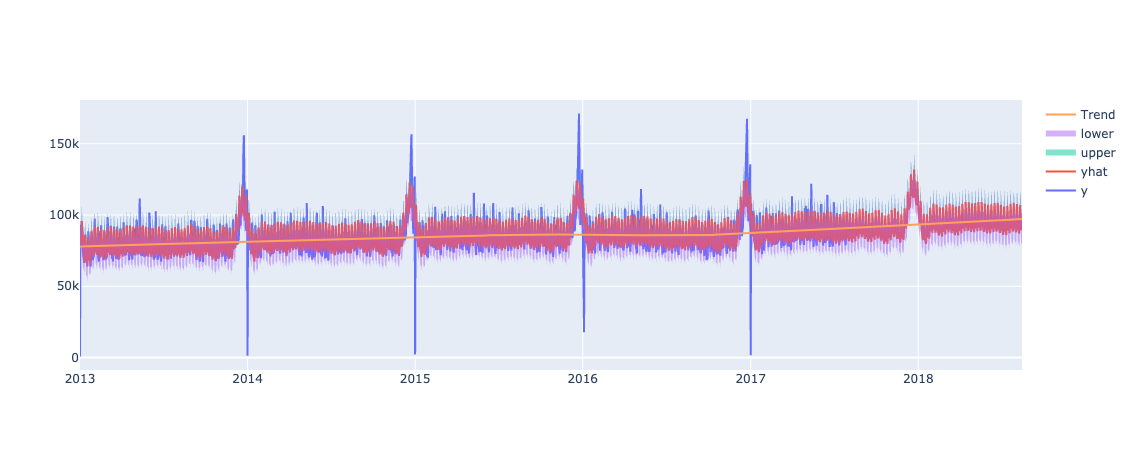

In [6]:
py.iplot([
    go.Scatter(x=transactions['ds'], y=transactions['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

In [7]:
# Calculate root mean squared error.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1682, 'yhat']-transactions['y'])**2)) )

RMSE: 7903.188084


As we see in the graph above, prediction is fairly well and aligns with the data's up and downs. You can zoom in the graph by selecting a zoom area with mouse.

But the trend is fairly rigid, it misses the sub trends in mid-years. The trend is rising at first half of the year and a little bit slowing down after that. Let's make the trend a little bit flexible. If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument **changepoint_prior_scale**. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible. (https://facebook.github.io/prophet/docs/trend_changepoints.html)

In [8]:
m = Prophet(changepoint_prior_scale=2.5)
m.fit(transactions)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 7860.811204


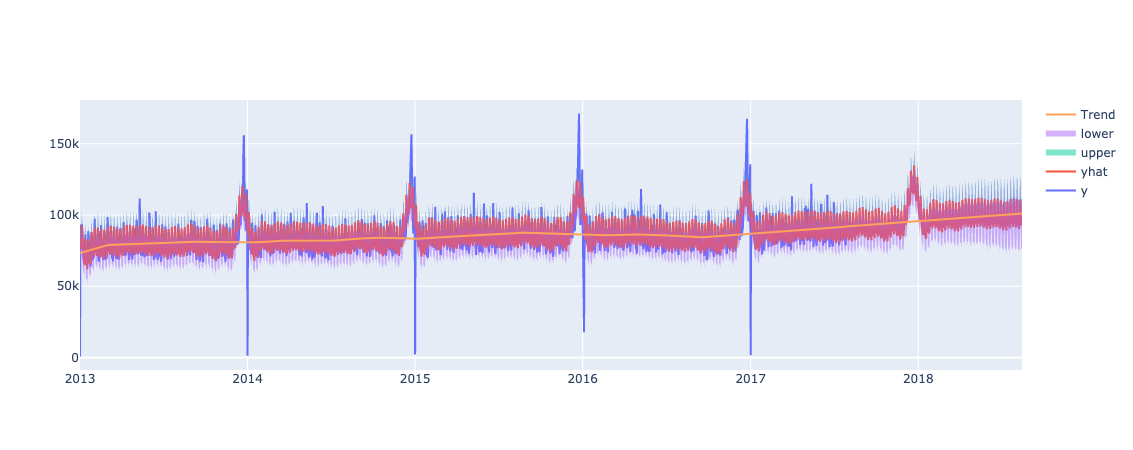

In [9]:
# Calculate root mean squared error.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1682, 'yhat']-transactions['y'])**2)) )
py.iplot([
    go.Scatter(x=transactions['ds'], y=transactions['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

Now we'll add more seasonality to the model. As we see, prophet calculates weekly and yearly seasonality. We don't need daily seasonality, because we don't have intra-day data for this tutorial. Just adding monthly seasonality should be enough.

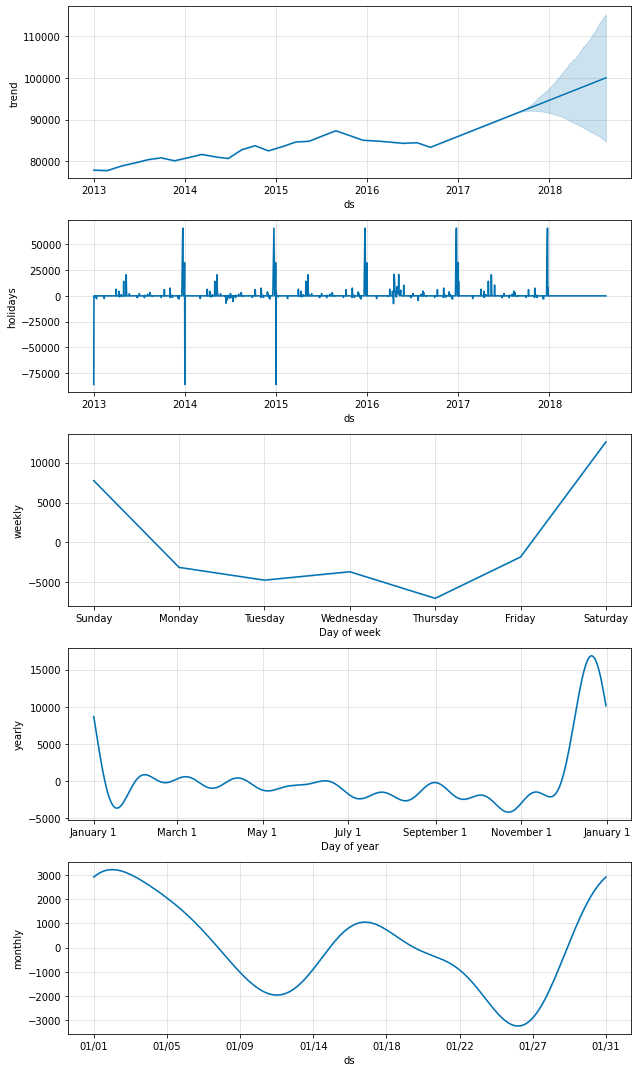

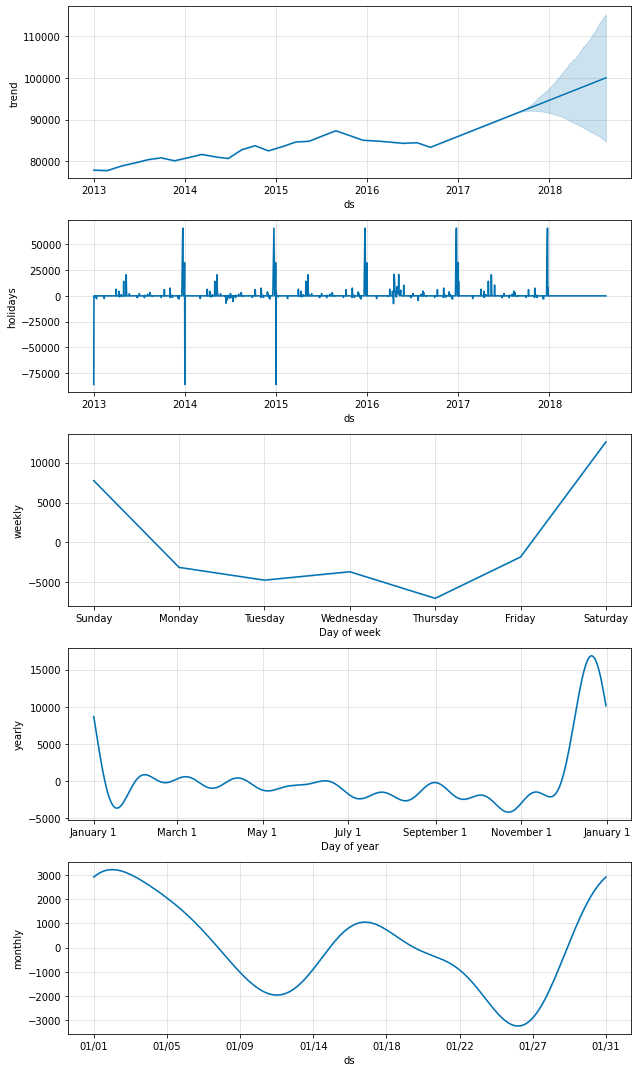

In [19]:
m.plot_components(forecast)

In [10]:
m = Prophet(changepoint_prior_scale=2.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(transactions)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 7681.506809


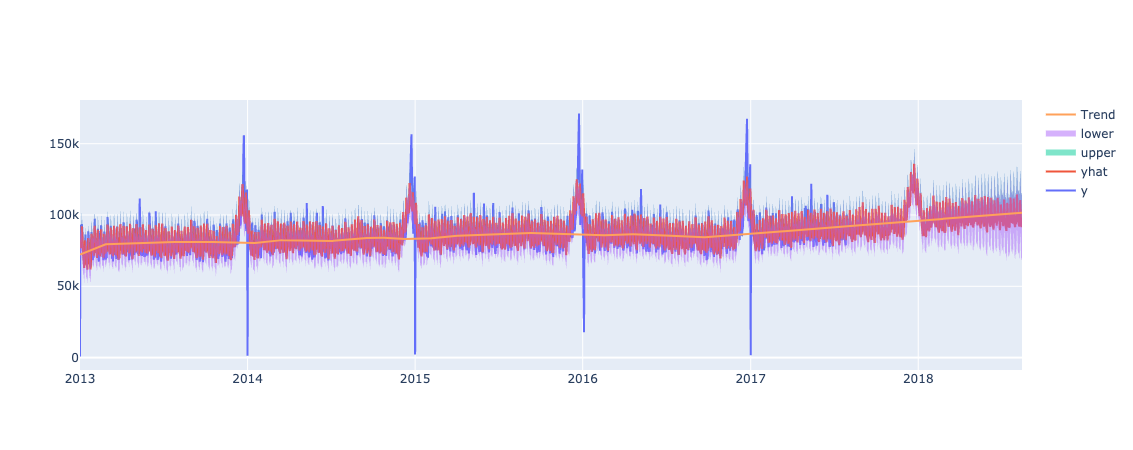

In [11]:
# Calculate root mean squared error.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1682, 'yhat']-transactions['y'])**2)) )
py.iplot([
    go.Scatter(x=transactions['ds'], y=transactions['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

Now it's time to add effects of holiday events into our model. We need to adjust data format first. Prophet needs two columns (holiday and ds) and a row for each occurrence of the holiday. We could also include columns lower_window and upper_window which extend the holiday out to `[lower_window, upper_window]` days around the date. But, I think data is arranged well and we don't have to pay so much attention to that.

In [12]:
df_holidays_events

date        type    locale locale_name  \
0    2012-03-02     Holiday     Local       Manta   
1    2012-04-01     Holiday  Regional    Cotopaxi   
2    2012-04-12     Holiday     Local      Cuenca   
3    2012-04-14     Holiday     Local    Libertad   
4    2012-04-21     Holiday     Local    Riobamba   
..          ...         ...       ...         ...   
345  2017-12-22  Additional  National     Ecuador   
346  2017-12-23  Additional  National     Ecuador   
347  2017-12-24  Additional  National     Ecuador   
348  2017-12-25     Holiday  National     Ecuador   
349  2017-12-26  Additional  National     Ecuador   

                       description  transferred  
0               Fundacion de Manta        False  
1    Provincializacion de Cotopaxi        False  
2              Fundacion de Cuenca        False  
3        Cantonizacion de Libertad        False  
4        Cantonizacion de Riobamba        False  
..                             ...          ...  
345                      Navidad-3        False  
346                      Navidad-2        False  
347                      Navidad-1        False  
348                        Navidad        False  
349                      Navidad+1        False  

[350 rows x 6 columns]

In [13]:
holidays = df_holidays_events[df_holidays_events['transferred'] == False][['description', 'date']]
holidays.columns = ['holiday', 'ds']
#holidays['lower_window'] = 0
#holidays['upper_window'] = 0
holidays

holiday          ds
0               Fundacion de Manta  2012-03-02
1    Provincializacion de Cotopaxi  2012-04-01
2              Fundacion de Cuenca  2012-04-12
3        Cantonizacion de Libertad  2012-04-14
4        Cantonizacion de Riobamba  2012-04-21
..                             ...         ...
345                      Navidad-3  2017-12-22
346                      Navidad-2  2017-12-23
347                      Navidad-1  2017-12-24
348                        Navidad  2017-12-25
349                      Navidad+1  2017-12-26

[338 rows x 2 columns]

In [14]:
m = Prophet(changepoint_prior_scale=2.5, holidays=holidays)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(transactions)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 4929.575239


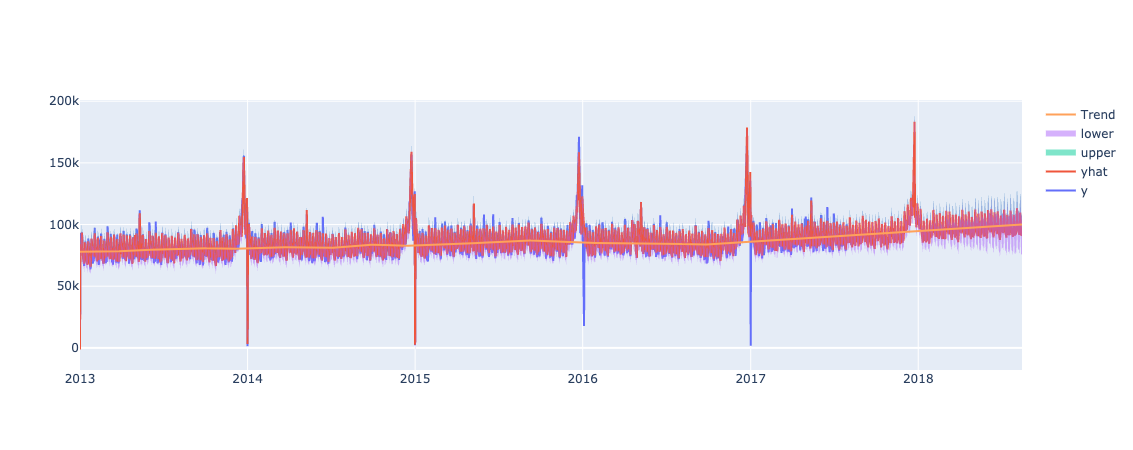

In [15]:
# Calculate root mean squared error.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1682, 'yhat']-transactions['y'])**2)) )
py.iplot([
    go.Scatter(x=transactions['ds'], y=transactions['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

We managed to predict the spikes for new-year period. The model couldn't catch the downward spike for Jan 4th 2016, so it could not predict Jan 1st 2017 successfully. That's very reasonable, as there is no holiday for Jan 4th of 2016. But the model predicts the sales on the 24th Decembers nicely. And also forecasted period after Aug 15th 2017 looks good.

And, as a non-ecuadorian person, I can say from the graph that "Dia de la Madre" is an important event, and it boosts sales previous day.

And, that's it. Prophet is a fairly easy to use library to forecast time-series data, which only uses previous data and holidays for that. There are more features and parameters like saturating forecasts, uncertanity intervals etc. which we didn't cover here. You can read more from their paper https://peerj.com/preprints/3190.pdf.

I think it's not a full-featured regression or forecasting tool, as we cannot use other data to use correlations or effects of another variable etc. But, It could be a replacement for time-series models like ARMA, ARIMA etc. Please comment below if you think you know more ways to improve this model. Thank you!